# Project: Investigate Gapminder Datasets

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

In the following notebook, we are going to explore three datasets from the Gapminder's rich collection. We will explore trends in individual datasets along with correlation between each other. We will make more sense of these datasets with vizualisations and gradually build our understanding of them with some geovizusaliation as well.

Due to the richness and sheer bulk of the data, along the way, we will make some assumptions and limit our analysis to the questions that are posed in the next block.

### The Data
There were three distinct datasets were chosen for these analysis. They are:
1. Oil Consumption total (tonnes per year)
2. Total income (GDP, constant exchange rate USD)
3. Total CO2 emissions from fossil-fuels (1000 metric tons) <br>
<br>

All three datasets are attached with this notebook.

### Questions
1. Which are top 5 countries that have consumed oil the most? What kind of impact does the oil consumption have on their $CO_{2}$ emissions? Does higher oil consumption have impact on their GDP?
2. What are the differences/similarities between top 2 oil consumers with respect to bottom 2 oil consumers?
3. How does developed and developing countries fare when it comes to these three parameters? We will try to find answer by exploring 3 developed and 3 developing nations!
4. How does the global trend over the period of time have developed? Old players holding their ground? Or new players are redefining the global outlook? We will plot this on the world map!!


**NOTE:**
> - In the later part of this notebook, we will use some nonconventional libraries. Although import section takes care of the missing libraries assuming default environment being Anaconda! <br>
> - If that is not the case, the please refer to the following link for installation on the fly <br>
> https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/ 

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sys
import itertools
import pylab as pl
from IPython import display
import matplotlib.patches as mpatches

try:
    import cartopy.crs as ccrs
except ModuleNotFoundError:
    !conda install --yes --prefix {sys.prefix} -c scitools cartopy
import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

%matplotlib inline

Now that, imports and missing libraries are installed and out of the way, let's get started.

<a id='wrangling'></a>
## Data Wrangling

Let's read in the files! The gapminder website provided the files in MS Excel format. Luckily pandas have function to read those too!!


In [2]:
# Read files to respective dataframes
df_oil = pd.read_excel('./data/oil_consumption.xlsx')
df_gdp = pd.read_excel('./data/GDP.xlsx')
df_co2 = pd.read_excel('./data/co2_total_emissions.xlsx')

In [3]:
# Overview of the dataset
df_oil.info()#, df_gdp.info(), df_co2.info() # Please uncomment the later part to see remainig two df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 48 columns):
Oil Consumption total (tonnes per year)    64 non-null object
1965                                       64 non-null object
1966                                       64 non-null object
1967                                       64 non-null object
1968                                       64 non-null object
1969                                       64 non-null object
1970                                       64 non-null object
1971                                       64 non-null object
1972                                       64 non-null object
1973                                       64 non-null object
1974                                       64 non-null object
1975                                       64 non-null object
1976                                       64 non-null object
1977                                       64 non-null object
1978                         

Info shows that all the columns have wide range of data types. So, first things first, let's homogenize the column types to strings. <br>
**Why strings?** <br>
Because at later point it will be easier to access and avoid confusion. As these are years, we don't want to create confusion with loads of other numbers floating around!

In [4]:
# setting column types as str. Column names with years are read as 'int'.

df_oil.columns = df_oil.columns.astype(str)
df_gdp.columns = df_gdp.columns.astype(str)
df_co2.columns = df_co2.columns.astype(str)

Also from the convenience point of view, the index column name can be changed to less-special-character-ish name <br>
Setting the `countries` as an index would not hurt either!!

In [5]:
# renaming the first column
df_oil.rename(columns={'Oil Consumption total (tonnes per year)':'countries_oil_tonnes_per_year'}, inplace=True)
df_gdp.rename(columns={'GDP (constant 2000 US$)':'countries_gdp_2000usd'}, inplace=True)
df_co2.rename(columns={'CO2 emission total':'countries_co2_total'}, inplace=True)


# setting country column as index
df_oil.set_index('countries_oil_tonnes_per_year', inplace=True)
df_gdp.set_index('countries_gdp_2000usd', inplace=True)
df_co2.set_index('countries_co2_total', inplace=True)

**Note:**
> Throughout the notebook, here onwards, we will consider `df_oil` to be our base dataframe <br>

> Therefore, in the analysis to follow, the years between `1965` to `2010` are considered <br>

> Also, NaN values are kept as some countries did not exist before a certain year.

In [6]:
# homogenizing data by limiting columns. All the data is from 1965 to 2010

col_list = [str(i) for i in range(1965, 2011, 1)]

df_oil = df_oil[col_list]
df_gdp = df_gdp[col_list]
df_co2 = df_co2[col_list]

In [7]:
# Save dataframes to an intermediate file
df_oil.to_csv('oil_consumption_cleaned', index=True, encoding='utf-8')
df_gdp.to_csv('gdp_cleaned', index=True, encoding='utf-8')
df_co2.to_csv('total_co2_emissions_cleaned', index=True, encoding='utf-8')

Now that basic wrangling is peroformed and saved to intermediate files, let'e move on to further clean the data. <br>
We start by reading the newly created intermediate files to respective dataframes!

### Data Cleaning

In [8]:
# read intermediate files to dataframes

df_oil = pd.read_csv('oil_consumption_cleaned', index_col=0) 
df_gdp = pd.read_csv('gdp_cleaned', index_col=0)
df_co2 = pd.read_csv('total_co2_emissions_cleaned', index_col=0)

Using info method on all three dataframes reveal that majority of the column values are strings. The numbers are big and needs to be converted to float. For which `pd.to_numeric` is a good way to handle that. However, `pd.to_numeric` by default creates `int`. So additionally we have to be specific that `dtype=float64` is what we are after for sake of homogeneity.

In [9]:
# converting all columns from str to float. additional '.astype' had to be used because some columns had data type of int
# pd.to_numeric only converts strings to floats and does not convert to ints

df_oil[list(df_oil.columns)] = df_oil[list(df_oil.columns)].apply(pd.to_numeric, errors='coerce').astype(dtype='float64')
df_gdp[list(df_gdp.columns)] = df_gdp[list(df_gdp.columns)].apply(pd.to_numeric, errors='coerce').astype(dtype='float64')
df_co2[list(df_co2.columns)] = df_co2[list(df_co2.columns)].apply(pd.to_numeric, errors='coerce').astype(dtype='float64')

In [10]:
# check if the number of columns are equal for all dataframes
df_oil.shape, df_gdp.shape, df_co2.shape

((64, 46), (270, 46), (275, 46))

Now, that `years` are consistent in all three dataframes, let's move on to fix the rows and index related inconsistencies. <br>
One way to achieve this is `list(df.index)` and manually go one by one to compare each `country` string. <br>
But with pandas, we can do this cleverly! <br>
<br>
The strategy remains the same, `df_oil` is our base dataframe. We will look for the indexes that exists in `df_oil` and compare those with `df_gdp` and `df_co2` respectively. 

In [11]:
# looking for indexes that exists in both df_oil and df_gdp

df_oil[~df_oil.index.isin(df_gdp.index)] # checks for the entries that are unique to df_oil when compared with similar entries in both dataframes

,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,...,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
countries_oil_tonnes_per_year,,,,,,,,,,,,,,,,,,,,,
Czech Rep.,3997000.0,4418000.0,4916000.0,5420000.0,5819000.0,6984000.0,7685000.0,8419000.0,9470000.0,9719000.0,...,8374000.0,8143000.0,8700000.0,9545000.0,9935000.0,9821000.0,9745000.0,9905000.0,9700000.0,9200000.0
"Korea, Rep.",1287000.0,1927000.0,3342000.0,4942000.0,6709000.0,8380000.0,9461000.0,9876000.0,12158000.0,12550000.0,...,103109000.0,104671000.0,105604000.0,104924823.0,105411495.0,105530226.0,108262883.0,103279024.0,103000000.0,100600000.0


In [12]:
df_oil[~df_oil.index.isin(df_co2.index)] # checks for the entries that are unique to df_oil when compared with similar entries in both dataframes

,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,...,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
countries_oil_tonnes_per_year,,,,,,,,,,,,,,,,,,,,,
Czech Rep.,3997000.0,4418000.0,4916000.0,5420000.0,5819000.0,6984000.0,7685000.0,8419000.0,9470000.0,9719000.0,...,8374000.0,8143000.0,8700000.0,9545000.0,9935000.0,9821000.0,9745000.0,9905000.0,9700000.0,9200000.0
"Korea, Rep.",1287000.0,1927000.0,3342000.0,4942000.0,6709000.0,8380000.0,9461000.0,9876000.0,12158000.0,12550000.0,...,103109000.0,104671000.0,105604000.0,104924823.0,105411495.0,105530226.0,108262883.0,103279024.0,103000000.0,100600000.0


Above two cells reveal that, our base dataframe `df_oil` has two rows which are named differently as compared to other two. Let's rename that for consistency. <br>
Additionally, there is also one row `Hong Kong, China` with a comma in it in all three dataframes. Let's change it to `Hong Kong` for the future ease.

In [13]:
# based upon above cell, change the country name for uniformity. 'Korea, Rep.' = 'South Korea' is based upon wikipedia
df_oil.rename(index={'Czech Rep.':'Czech Republic', 'Korea, Rep.':'South Korea', 'Hong Kong, China':'Hong Kong'}, inplace=True)
df_gdp.rename(index={'Hong Kong, China':'Hong Kong'}, inplace=True)
df_co2.rename(index={'Hong Kong, China':'Hong Kong'}, inplace=True)

In [14]:
# quick check of shape, just to make sure we didn't break anything in the meanwhile 
df_oil.shape, df_gdp.shape, df_co2.shape

((64, 46), (270, 46), (275, 46))

Now that the `df_oil`, which we are using as a base dataframe, is smoothened in the index. Let's move on to keep the countries in the other two dataframes that matches our base `df_oil`

In [15]:
# only keep the indexes that are in base dataframe df_oil and flatten the other two
df_co2 = df_co2[df_co2.index.isin(df_oil.index)]
df_gdp = df_gdp[df_gdp.index.isin(df_oil.index)]

In [16]:
# sanity check with shape
df_oil.shape, df_gdp.shape, df_co2.shape

((64, 46), (64, 46), (64, 46))

**Almost There!!**

Normally, we can simply save these dataframes to another set of intermediate files and move on to exploration and vizualisation. But the road we want to take for exploration and vizualisation, it would be nice to make `years` as an index column. <br>
Plus, remove the spaces in the column names and replace them by `_`.

In [17]:
# transposing the dataframe so that it is easy to use.
df_oil = df_oil.transpose()
df_gdp = df_gdp.transpose()
df_co2 = df_co2.transpose()

In [18]:
# remove spaces in the column names and replace those with underscores
df_oil.rename(columns=lambda x: x.lower(), inplace=True)
df_oil.columns = df_oil.columns.str.replace(' ', '_')

df_gdp.rename(columns=lambda x: x.lower(), inplace=True)
df_gdp.columns = df_gdp.columns.str.replace(' ', '_')

df_co2.rename(columns=lambda x: x.lower(), inplace=True)
df_co2.columns = df_co2.columns.str.replace(' ', '_')

In [19]:
# check if all the column names match
df_oil.columns == df_gdp.columns, df_oil.columns == df_co2.columns

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool),
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,

In [20]:
df_oil.head()

countries_oil_tonnes_per_year,algeria,argentina,australia,austria,azerbaijan,bangladesh,belarus,brazil,bulgaria,canada,...,taiwan,thailand,turkey,turkmenistan,ukraine,united_arab_emirates,united_kingdom,united_states,uzbekistan,venezuela
1965,1289000.0,21952000.0,16902000.0,5534000.0,NaN,NaN,NaN,14878000.0,3702000.0,53835000.0,...,2164000.0,2300000.0,5021000.0,NaN,NaN,NaN,74223000.0,548933000.0,NaN,9340000.0
1966,1693000.0,22678000.0,18120000.0,6068000.0,NaN,NaN,NaN,16218000.0,4226000.0,56711000.0,...,2564000.0,2719000.0,4548000.0,NaN,NaN,NaN,79472000.0,575664000.0,NaN,9448000.0
1967,1578000.0,23224000.0,19812000.0,6491000.0,NaN,NaN,NaN,16759000.0,5316000.0,60566000.0,...,3050000.0,3023000.0,5595000.0,NaN,NaN,NaN,85254000.0,595761000.0,NaN,9504000.0
1968,1682000.0,23733000.0,21892000.0,7513000.0,NaN,NaN,NaN,20139000.0,6300000.0,64477000.0,...,3643000.0,3993000.0,6370000.0,NaN,NaN,57000.0,90388000.0,635452000.0,NaN,10034000.0
1969,1775000.0,24671000.0,23425000.0,8253000.0,NaN,NaN,NaN,22109000.0,7736000.0,67135000.0,...,4369000.0,4330000.0,7061000.0,NaN,NaN,95000.0,97321000.0,667791000.0,NaN,10016000.0


In [21]:
# Save dataframes to an intermediate file
df_oil.to_csv('oil_consumption_final', index=True, encoding='utf-8')
df_gdp.to_csv('gdp_final', index=True, encoding='utf-8')
df_co2.to_csv('total_co2_emissions_final', index=True, encoding='utf-8')

<a id='eda'></a>
## Exploratory Data Analysis

### Which are top 5 countries that have consumed oil the most? What kind of impact does the oil consumption have on their $CO_{2}$ emissions? Does higher oil consumption have impact on their GDP?

In the following section we will explore 'global' time series of oil consumption with respect to $CO_{2}$ emissions followed by the GDP

In [22]:
# read files to dataframes
df_oil = pd.read_csv('oil_consumption_final',index_col=0)
df_gdp = pd.read_csv('gdp_final', index_col=0)
df_co2 = pd.read_csv('total_co2_emissions_final', index_col=0)

In [23]:
# Mean consumption of all the countries over the time period of 1965 to 2010
top5_oil = df_oil.mean(axis=0).sort_values(ascending=False).head()
top5_co2 = df_co2.mean(axis=0).sort_values(ascending=False).head()
top5_gdp = df_gdp.mean(axis=0).sort_values(ascending=False).head()

In [24]:
top5_oil, top5_co2, top5_gdp

(united_states    7.968702e+08
 japan            2.266134e+08
 russia           1.681207e+08
 china            1.467656e+08
 germany          1.307887e+08
 dtype: float64, united_states    4.888840e+06
 china            2.730431e+06
 russia           1.657610e+06
 japan            1.011330e+06
 germany          9.495523e+05
 dtype: float64, united_states     6.971207e+12
 japan             3.496732e+12
 germany           1.529426e+12
 united_kingdom    1.107461e+12
 france            1.011690e+12
 dtype: float64)

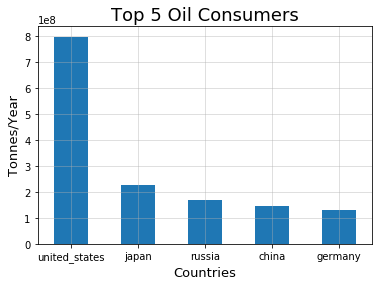

In [25]:
# top 5 oil consumers

top5_oil.plot(kind='bar', rot='horizontal')
plt.xlabel('Countries', fontsize=13)
plt.ylabel('Tonnes/Year', fontsize=13)
plt.title('Top 5 Oil Consumers', fontsize=18)
plt.grid(alpha=0.5);

United States of America is the highest consumer of the oil. Japan being the second higest. One interesting thing to notice in these numbers is that USA consumes more than rest of the 4 combined. <br>
Although, China, not being a top oil consumers, nor one of the top GDPs, it appears to be emitting high amounts of $CO_{2}$

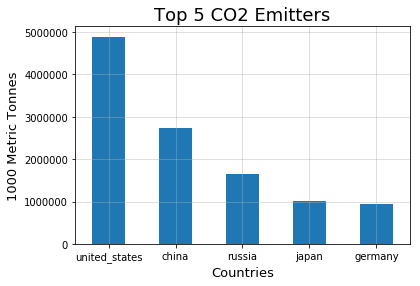

In [26]:
# top 5 co2 emmitters

top5_co2.plot(kind='bar', rot='horizontal')
plt.xlabel('Countries', fontsize=13)
plt.ylabel('1000 Metric Tonnes', fontsize=13)
plt.title('Top 5 CO2 Emitters', fontsize=18)
plt.grid(alpha=0.5);

China and Russia both are developing and growing economies. Especially China, is growing at a great rate in all the sectors. Plus, one of the attribute that can be adding to high Carbon Dioxide emissions is higher use of coal as well.

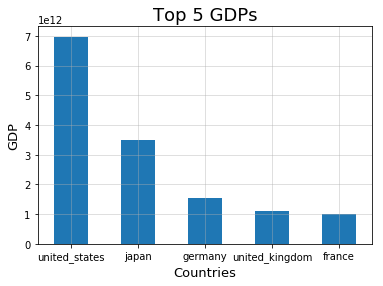

In [27]:
# top 5 GDPs
top5_gdp.plot(kind='bar', rot='horizontal')
plt.xlabel('Countries', fontsize=13)
plt.ylabel('GDP', fontsize=13)
plt.title('Top 5 GDPs', fontsize=18)
plt.grid(alpha=0.5);

Keeping `df_oil` as our base DF, we are going to look at the top 5 oil consumer countries and their respective co2 emmisions followed by GDP over the time period

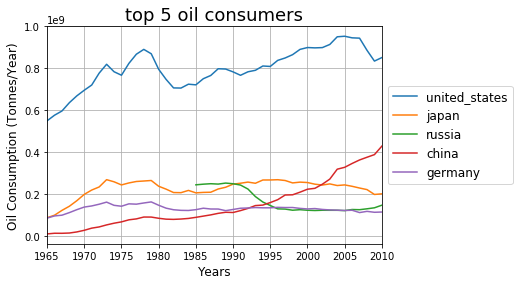

In [28]:
# plotting all top 5 oil consumers

ax = df_oil[top5_oil.index].plot()
ax.grid()
ax.set_xlabel('Years', fontsize=12)
ax.set_ylabel('Oil Consumption (Tonnes/Year)', fontsize=12)
ax.set_title('top 5 oil consumers', fontsize=18)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12);

Above graph suggests that the oil consumption in those countries have been more or less stable except for US and China. China being the emerging economy, it is natural that oil consumption increases steadily over the time. However, looking at the other countries, the consumption is more or less stable over the chosen time period.

### What are the differences/similarities between top 2 oil consumers with respect to bottom 2 oil consumers?

(0.94290280244716951, 0.78219310186462643)

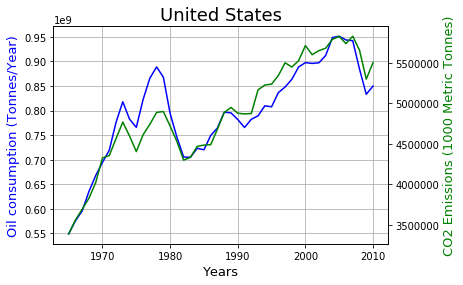

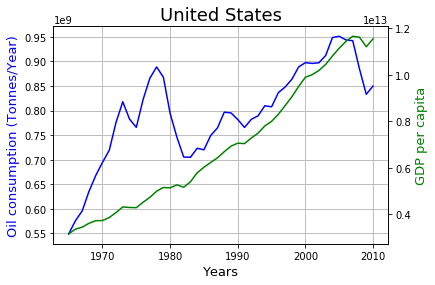

In [29]:
# plotting oil and co2

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(df_oil.united_states, color='b')
ax2.plot(df_co2.united_states, color='g')

ax1.set_xlabel('Years', fontsize=13)
ax1.grid()
ax1.set_ylabel('Oil consumption (Tonnes/Year)', color='b', fontsize=13)
ax2.set_ylabel('CO2 Emissions (1000 Metric Tonnes)', color='g', fontsize=13)
plt.title('United States', fontsize=18);

# plotting oil and gdp

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(df_oil.united_states, color='b')
ax2.plot(df_gdp.united_states, color='g')

ax1.set_xlabel('Years', fontsize=13)
ax1.grid()
ax1.set_ylabel('Oil consumption (Tonnes/Year)', color='b', fontsize=13)
ax2.set_ylabel('GDP per capita', color='g', fontsize=13)
plt.title('United States', fontsize=18);

# compute correlation coefficient
df_oil.united_states.corr(df_co2.united_states), df_oil.united_states.corr(df_gdp.united_states)

The plots above give a great insight to how these indicators are correlated to each other. Especially, oil consumption and $CO_{2}$ emissions. In the cell below, we compute the correlation coefficient to confirm our reading of the graph. <br>
Another interesting thing to read from second plot is the steady increase in the the GDP of USA over the years. The infamous economic crisis of 2008 is clearly visible in the GDP plot as well as recovery in both the indicators.

In [30]:
# compute correlation coefficient
df_oil.united_states.corr(df_co2.united_states), df_oil.united_states.corr(df_gdp.united_states)

(0.94290280244716951, 0.78219310186462643)

From the correlation coefficient, it is clearly visible that oil consumption and $CO_{2}$ emissions are strongly correlated. GDP as well, but not as strong as emissions! Now, let's look at Japan. The second biggest oil consumer.

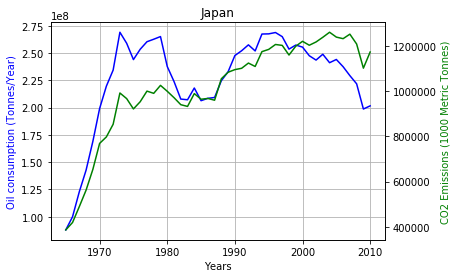

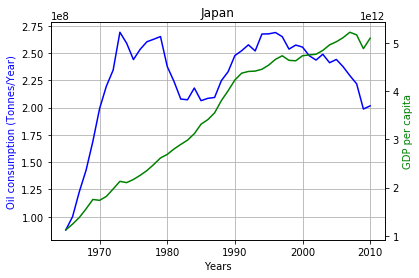

In [31]:
# plotting oil and co2

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(df_oil.japan, color='b')
ax2.plot(df_co2.japan, color='g')

ax1.set_xlabel('Years')
ax1.grid()
ax1.set_ylabel('Oil consumption (Tonnes/Year)', color='b')
ax2.set_ylabel('CO2 Emissions (1000 Metric Tonnes)', color='g')
plt.title('Japan');

# plotting oil and gdp

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(df_oil.japan, color='b')
ax2.plot(df_gdp.japan, color='g')

ax1.set_xlabel('Years')
ax1.grid()
ax1.set_ylabel('Oil consumption (Tonnes/Year)', color='b')
ax2.set_ylabel('GDP per capita', color='g')
plt.title('Japan');

In [32]:
# compute correlation coefficient
df_oil.japan.corr(df_co2.japan), df_oil.japan.corr(df_gdp.japan)

(0.82621188423029923, 0.52904660227330702)

Japan shows the same characteristics as of USA in both the indicators. However, the oil to co2 correlation is not as strong as USA. Especially, for oil to GDP is very low.

In [33]:
bot5_oil = df_oil.mean(axis=0).sort_values(ascending=False).tail()
bot5_co2 = df_co2.mean(axis=0).sort_values(ascending=False).tail()
bot5_gdp = df_gdp.mean(axis=0).sort_values(ascending=False).tail()
bot5_oil.head()

ecuador         4.262420e+06
turkmenistan    4.083029e+06
bangladesh      2.510262e+06
qatar           1.448658e+06
iceland         6.835385e+05
dtype: float64

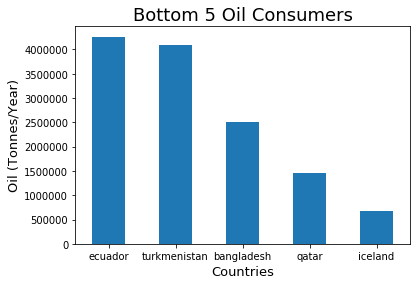

In [34]:
bot5_oil.plot(kind='bar', rot='horizontal')
plt.xlabel('Countries', fontsize=13)
plt.ylabel('Oil (Tonnes/Year)', fontsize=13)
plt.title('Bottom 5 Oil Consumers', fontsize=18);

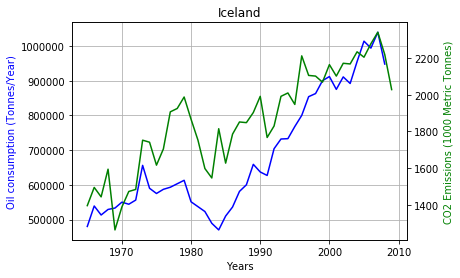

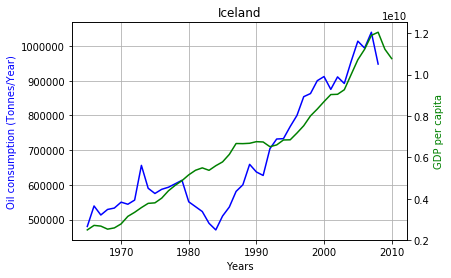

In [35]:
# plotting oil and co2

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(df_oil.iceland, color='b')
ax2.plot(df_co2.iceland, color='g')

ax1.set_xlabel('Years')
ax1.grid()
ax1.set_ylabel('Oil consumption (Tonnes/Year)', color='b')
ax2.set_ylabel('CO2 Emissions (1000 Metric Tonnes)', color='g')
plt.title('Iceland');

# plotting oil and gdp

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(df_oil.iceland, color='b')
ax2.plot(df_gdp.iceland, color='g')

ax1.set_xlabel('Years')
ax1.grid()
ax1.set_ylabel('Oil consumption (Tonnes/Year)', color='b')
ax2.set_ylabel('GDP per capita', color='g')
plt.title('Iceland');

Iceland being the least consumer of the oil in the list. But the correlation with $CO_{2}$ emissions is real. The peaks and valleys do indeed go hand in hand. Same goes for GDP. Although between 1980s and 1990s, the oil consumption dropped drastically only to be picked up again afterwards, the increase in GDP followed a steady path. <br>
The impact of 2008 banking crisis in Iceland is evident in the fall of GDP and most likely into the oil consumption as well.

In [36]:
# compute correlation coefficient
df_oil.iceland.corr(df_co2.iceland), df_oil.iceland.corr(df_gdp.iceland)

(0.87084282698161797, 0.88828462704994493)

As mentioned before, even though the correlation is high between oil and GDP but given such a complex socio-economical aspect, it can not be denied that few other variables can have impact on both of them rather than these two solely upon each other!

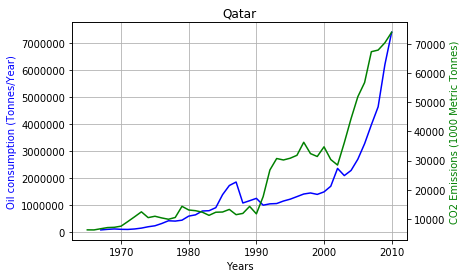

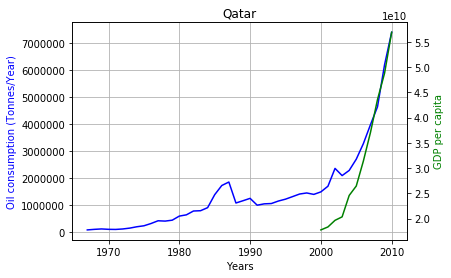

In [37]:
# plotting oil and co2

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(df_oil.qatar, color='b')
ax2.plot(df_co2.qatar, color='g')

ax1.set_xlabel('Years')
ax1.grid()
ax1.set_ylabel('Oil consumption (Tonnes/Year)', color='b')
ax2.set_ylabel('CO2 Emissions (1000 Metric Tonnes)', color='g')
plt.title('Qatar');

# plotting oil and gdp

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(df_oil.qatar, color='b')
ax2.plot(df_gdp.qatar, color='g')

ax1.set_xlabel('Years')
ax1.grid()
ax1.set_ylabel('Oil consumption (Tonnes/Year)', color='b')
ax2.set_ylabel('GDP per capita', color='g')
plt.title('Qatar');

Qatar being the second lowest oil consumer in our list has a vey high correlation in oil and emissions. As well as GDP. Qatar being the richest country in the world and economy running on oil export, it is no surprise that the correlation between oil consumption and GDP goes hand in hand.

In [38]:
# compute correlation coefficient
df_oil.qatar.corr(df_co2.qatar), df_oil.qatar.corr(df_gdp.qatar)

(0.90284555316845028, 0.98628206284122888)

There numbers just prove the above statement.

### How does developed and developing countries fare when it comes to these three parameters? We will try to find answer by exploring 3 developed and 3 developing nations!
<br>
In the following section, we will explore trends of 3 developing nations: China, Brazil and India along with 3 developed nations: France, Germany and UK

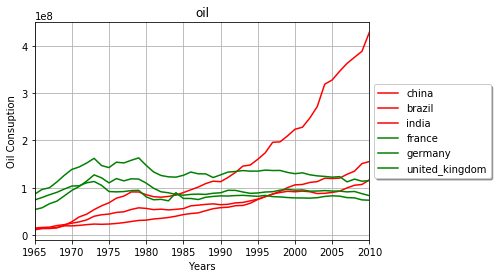

In [39]:
df_oil[['china','brazil','india','france','germany','united_kingdom']].plot(title='oil', color=['r','r','r','g','g','g'])
plt.grid()
plt.xlabel('Years')
plt.ylabel('Oil Consuption')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          fancybox=True, shadow=True);

The developed nations aka matured economies shows a relatively steady path of oil consumption. In fact, that of a gradual decline as opposed to constant increase in oil consumption in the developing nations. China's consumption gigantically increased in the past three decades. Almost four folds increase.

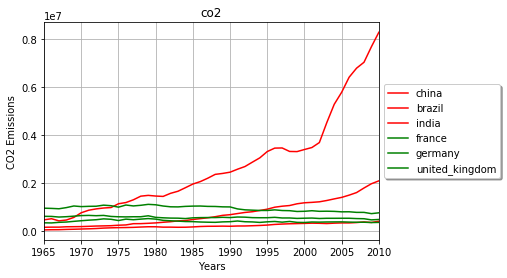

In [40]:
df_co2[['china','brazil','india','france','germany','united_kingdom']].plot(title='co2', color=['r','r','r','g','g','g'])
plt.grid()
plt.xlabel('Years')
plt.ylabel('CO2 Emissions')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          fancybox=True, shadow=True);

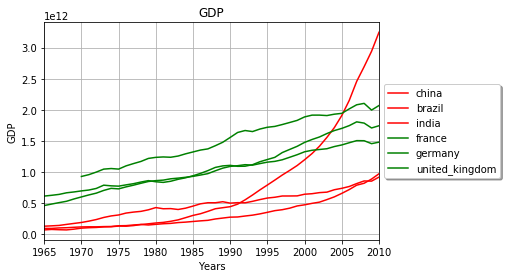

In [41]:
df_gdp[['china','brazil','india','france','germany','united_kingdom']].plot(title='GDP', color=['r','r','r','g','g','g'])
plt.grid()
plt.xlabel('Years')
plt.ylabel('GDP')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          fancybox=True, shadow=True);

The GDPs of developed nations show the implications of 2008's financial crisis. But surprisingly developing nations show no impact of the event in their GDP numbers.

### How does the global trend over the period of time have developed? Old players holding their ground? Or new players are redefining the global outlook? We will plot this on the world map!!

In the following section, we will try to visualize the over global trends, first for Oil vs $CO_{2}$ and then Oil vs GDP

In [42]:
def global_trends_animation(x_df, y_df, x_label, y_label):
    """
    This function plots the animation of global trends
    input param: x_df, y_df --> dataframe
                 x_label, y_label --> string
    output: series of plots that looks like an animation
    """
    years = list(x_df.index)
    cmap = mpl.cm.coolwarm

    for year in years:
        mean_x_df = x_df.loc[year].mean()
        mean_y_df = y_df.loc[year].mean()
        # close figure, to remove the figure generated by previous loop
        plt.clf()
        plt.grid()
        # legends
        grey_patch = mpatches.Patch(color='grey', label=year)
        v_mean = plt.axvline(mean_x_df, label='mean')
        h_mean = plt.axhline(mean_y_df)
        plt.legend(handles=[grey_patch, v_mean])
        # scatter plot
        plt.xlim(xmax=x_df.max().max() + 1000000, xmin=x_df.min().min() - 10000)    
        plt.scatter(x=x_df.loc[year], y=y_df.loc[year], s=(x_df.loc[year]/mean_x_df)*12**2, color=cmap(x_df.loc[year]/mean_x_df, 1))
        plt.xlabel(x_label, fontsize=15)
        plt.ylabel(y_label, fontsize=15)
        plt.title('Global Trends', fontsize=18)
        plt.semilogx() # semilog on x-axis for better visibility
        # magic part that does the animation job
        fig = pl.gcf()
        fig.set_size_inches(12.5, 8.5)
        display.display(fig)
        display.clear_output(wait=True);

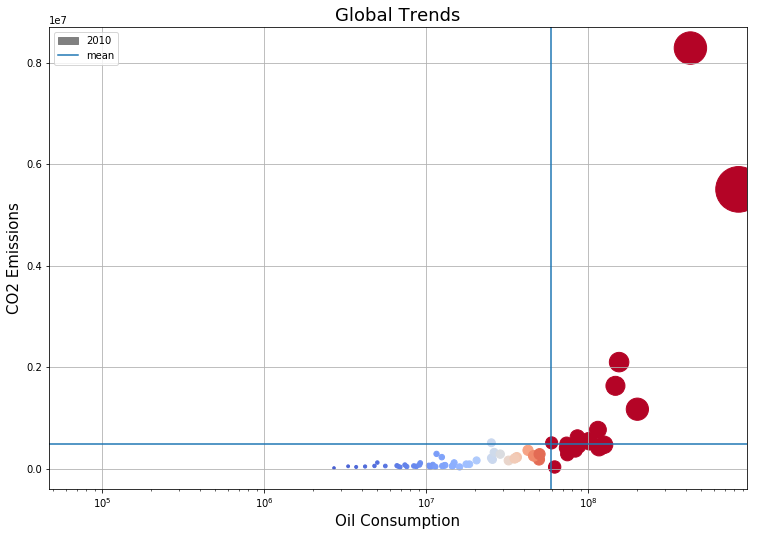

In [43]:
global_trends_animation(df_oil, df_co2, 'Oil Consumption', 'CO2 Emissions')

The animation above simply shows the above observed trends in a concise manner. We see China rapidly taking over USA in emissions in mid 2000s. However, USA still holds the first place undisputably the highest consumer of oil in the world. Far ahead from any nearby neighbors in ranking

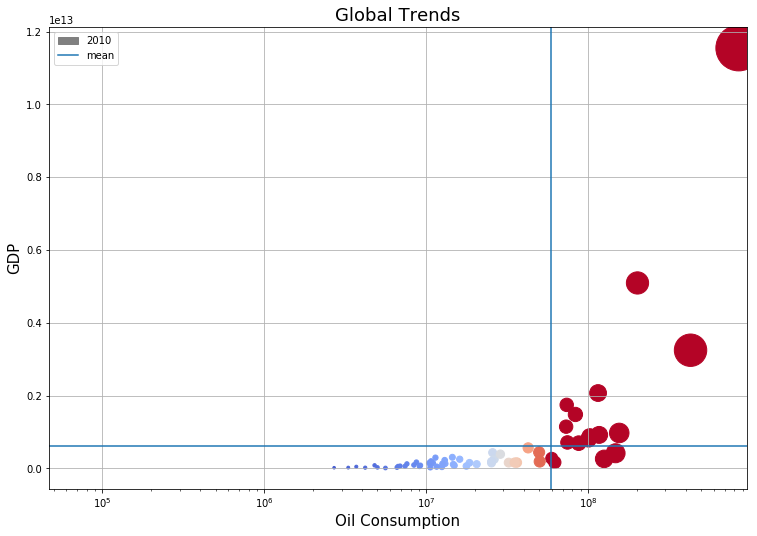

In [44]:
global_trends_animation(df_oil, df_gdp, 'Oil Consumption', 'GDP')

Similary, the oil consumption and GDP has a strong correlation. However, it is not simple to imply the causation of one as an effect of another. These are highly complicated socio-geo-economical areas dependent upon plenty of other static, dynamic and temporal factors.

In an final attempt to conclude, as the picture speaks better story than written words. Following is a visualization of  cummulative scenario of our datasets on a map. <br>
A quick overview of the strategy:
- We are going to read a shapefile containing geometries of the world from naturalEarth website.
- I have gone through the list of country names and checked for the (in)consistencies, which are anyway taken care of in the function!!
- The final map is saved as png
- Also, in our datasets, USA is top ranking country. This causes esthetic and cosmetic problems in the map visualization. Due to the nature of very high values, subsequent values are dampened in our viz. Therefore, in all the geoviz, USA will appear as RED
- Countries for which we do not have data available are shown as GREY

In [45]:
def geo_viz(df, plt_title, savefig_name_png):
    """
    This function plots a map of cummulative values in our dataframe.
    Inspiration for this one comes from: 
    https://stackoverflow.com/questions/41291534/make-colorbar-legend-in-matplotlib-cartopy/41587344#41587344
    
    input params: df --> dataframe
                  plt_title --> string for plot title
                  savefig_name_png --> string for output file to be saved as png
    output: A Choropleth map!!
            PNG file saved in the same directory
    """
    df_mean = df.describe().loc['mean'].to_dict() # convert to dict
    total_mean = sorted(list(df_mean.values()))[-2] # omitting USA for normalisation
    cmap = mpl.cm.Greens # colormap
    
    # prepare map axis and load shapefile
    shapename = 'admin_0_countries'
    countries_shp = shpreader.natural_earth(resolution='50m',
                                        category='cultural', name=shapename)
    ax = plt.axes(projection=ccrs.Robinson())
    
    # loop for each country's geometry for plotting
    for country in shpreader.Reader(countries_shp).records():
        name = country.attributes['NAME_LONG'].lower().replace(' ', '_')

        # changing names to have similar to our dataframe naming convention
        if name == 'russian_federation':
            name = 'russia'
        elif name == 'slovakia':
            name = 'slovak_republic'
        elif name == 'dem._rep._korea':
            name = 'south_korea'

        data_val = 0
        if name in df_mean.keys():
            data_val = df_mean[name]
            if name == 'united_states':
                ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                        facecolor='Red')
            else:
                ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                        facecolor=cmap(data_val/total_mean, 1))
        else:
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                        facecolor='#bfbfbf')
    
    ax.add_feature(cartopy.feature.OCEAN)
    ax.add_feature(cartopy.feature.COASTLINE)
    ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5)
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.title(plt_title, fontsize=20)
    plt.savefig(savefig_name_png);

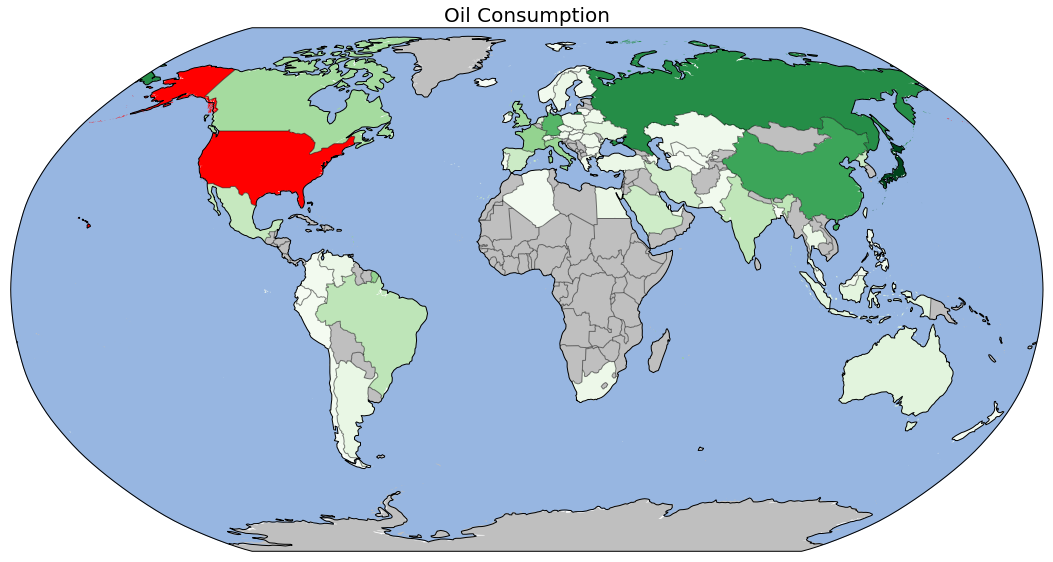

In [46]:
geo_viz(df_oil, 'Oil Consumption', 'Oil Consumption_Choropleth.png')

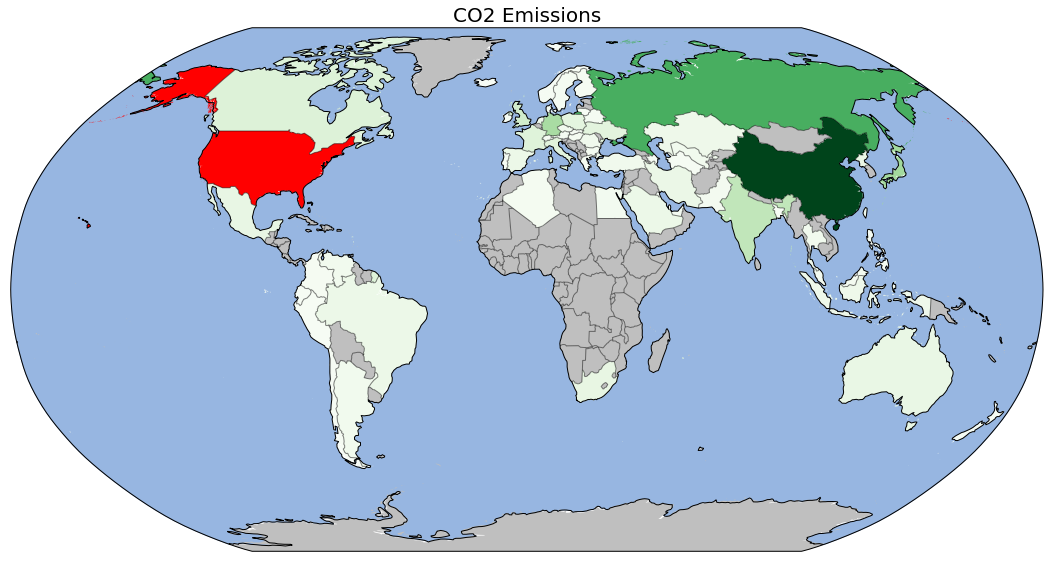

In [47]:
geo_viz(df_co2, 'CO2 Emissions', 'Oil Consumption_Choropleth.png')

C:\Users\Prayag\AppData\Roaming\Python\Python36\site-packages\matplotlib\colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


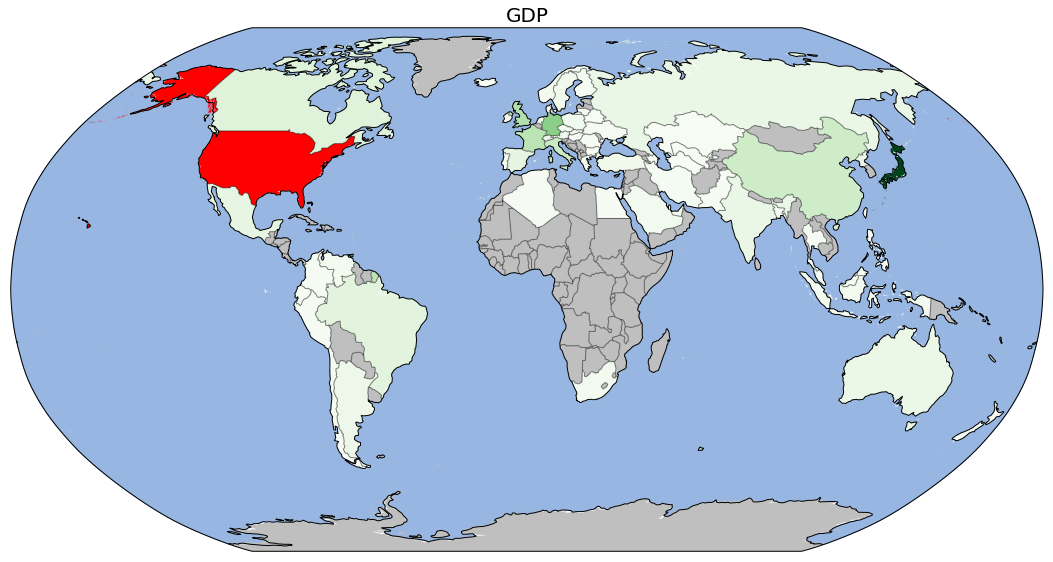

In [48]:
geo_viz(df_gdp, 'GDP', 'GDP_Choropleth.png')

<a id='conclusions'></a>
## Conclusions and Limitations

We looked at top 5 oil consumers in the world. USA being far, far ahead in the consumpion. Even combined consumption of subsequent top four consumers can not match that of USA's. Undisputably, this causes more Carbon Dioxide Emissions too. And USA enjoys the first place in that sector too. With current political on-goings we can only expect the emissions to increase. Although, China is second highest emitter of $CO_{2}$ is not surprising. One of the fastest growing economy and industrialization is well visible in the emissions as well as GDP data. But the correlation with oil cunsumption is relatively low, which suggests the dependence of China on other fossil fuels like Coal. <br>

When comparing 3 developing and developed economies, we saw significant difference in the trend. While China, India and Brazil are steadily and rapidly growing in our indicators. Although matured economies are showing slight decline in oil consumption. With climate awareness and treaties like Paris Climate Agreements in forefront, we can only expect the oil consumptions to decline within heavily industrialized economies. It would be rather great to compare with renewable energy data side-by-side.

The growth in GDP can be certainly tagged with oil consumption. And increasing Carbon Dioxide emissions as a by product of the 'growth'. If existing trends continue with high oil consumption and higher fossil fuel based $CO_{2}$ emissions. The climate change, rising global temperatures and mean sea level is reality of the future. We must embrace for it. Or act upon it to push for more non-conventional and renewable energy innovations.

Throughout our journey, as we explored and visualize the data. We saw some strong correlations between chosen indicators, however, in this frame of work with just three datasets, it would be biased and unwise to conclude one indicator's effect on another simply by looking at a bunch of plots. Oil Consumption, $CO_{2}$ Emissions and GDP data are a result of complex socio-economical factors. Impact of one indicator might be visible into another, but we can not firmly conclude without exploring a range of dependent variable data. However, this was clear from the beginning that, within scope of such small project, it is hard to justify such a mammoth datasets. It would perhaps take a thesis to properly explore, explain and conclude from these datasets.